In [11]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from tqdm import tqdm
from matplotlib import pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
bs = 100

# MNIST Dataset
transform = transforms.Compose([
transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])

train_dataset = datasets.FashionMNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./mnist_data/', train=False, transform=transform, download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [13]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

In [14]:
# build network
z_dim = 100
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

In [15]:
G

Generator(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
)

In [16]:
D

Discriminator(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
)

In [17]:
# loss
criterion = nn.BCELoss() 

# optimizer
lr = 0.0002 
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

In [18]:
def D_train(x):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real
    x_real, y_real = x.view(-1, mnist_dim), torch.ones(bs, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on facke
    z = Variable(torch.randn(bs, z_dim).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(bs, 1).to(device))

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

In [19]:
def G_train(x):
    #=======================Train the generator=======================#
    G.zero_grad()

    z = Variable(torch.randn(bs, z_dim).to(device))
    y = Variable(torch.ones(bs, 1).to(device))

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

100%|██████████| 600/600 [00:25<00:00, 23.70it/s]


[1/500]: loss_d: 0.672, loss_g: 3.598


100%|██████████| 600/600 [00:27<00:00, 21.46it/s]


[2/500]: loss_d: 0.277, loss_g: 6.391


100%|██████████| 600/600 [00:22<00:00, 26.72it/s]


[3/500]: loss_d: 0.465, loss_g: 3.431


100%|██████████| 600/600 [00:25<00:00, 23.13it/s]


[4/500]: loss_d: 0.324, loss_g: 3.897


100%|██████████| 600/600 [00:26<00:00, 22.50it/s]


[5/500]: loss_d: 0.458, loss_g: 3.157


100%|██████████| 600/600 [00:26<00:00, 22.73it/s]


[6/500]: loss_d: 0.498, loss_g: 2.894


100%|██████████| 600/600 [00:26<00:00, 22.39it/s]


[7/500]: loss_d: 0.582, loss_g: 2.649


100%|██████████| 600/600 [00:26<00:00, 23.07it/s]


[8/500]: loss_d: 0.662, loss_g: 2.343


100%|██████████| 600/600 [00:32<00:00, 18.69it/s]


[9/500]: loss_d: 0.675, loss_g: 2.323


100%|██████████| 600/600 [00:30<00:00, 19.37it/s]


[10/500]: loss_d: 0.754, loss_g: 1.997


100%|██████████| 600/600 [00:21<00:00, 27.77it/s]


[11/500]: loss_d: 0.806, loss_g: 1.917


100%|██████████| 600/600 [00:24<00:00, 24.98it/s]


[12/500]: loss_d: 0.772, loss_g: 1.884


100%|██████████| 600/600 [00:23<00:00, 25.33it/s]


[13/500]: loss_d: 0.799, loss_g: 1.866


100%|██████████| 600/600 [00:29<00:00, 20.23it/s]


[14/500]: loss_d: 0.813, loss_g: 1.857


100%|██████████| 600/600 [00:24<00:00, 24.38it/s]


[15/500]: loss_d: 0.838, loss_g: 1.763


100%|██████████| 600/600 [00:30<00:00, 19.58it/s]


[16/500]: loss_d: 0.842, loss_g: 1.769


100%|██████████| 600/600 [00:29<00:00, 20.25it/s]


[17/500]: loss_d: 0.831, loss_g: 1.708


100%|██████████| 600/600 [00:25<00:00, 23.55it/s]


[18/500]: loss_d: 0.846, loss_g: 1.747


100%|██████████| 600/600 [00:30<00:00, 19.76it/s]


[19/500]: loss_d: 0.860, loss_g: 1.700


100%|██████████| 600/600 [00:31<00:00, 18.76it/s]


[20/500]: loss_d: 0.899, loss_g: 1.605


100%|██████████| 600/600 [00:30<00:00, 19.83it/s]


[21/500]: loss_d: 0.926, loss_g: 1.520


100%|██████████| 600/600 [00:26<00:00, 22.62it/s]


[22/500]: loss_d: 0.902, loss_g: 1.581


100%|██████████| 600/600 [00:29<00:00, 20.38it/s]


[23/500]: loss_d: 0.922, loss_g: 1.505


100%|██████████| 600/600 [00:25<00:00, 23.09it/s]


[24/500]: loss_d: 0.930, loss_g: 1.507


100%|██████████| 600/600 [00:25<00:00, 23.32it/s]


[25/500]: loss_d: 0.918, loss_g: 1.520


100%|██████████| 600/600 [00:35<00:00, 16.87it/s]


[26/500]: loss_d: 0.929, loss_g: 1.490


100%|██████████| 600/600 [00:28<00:00, 21.03it/s]


[27/500]: loss_d: 0.927, loss_g: 1.473


100%|██████████| 600/600 [00:30<00:00, 19.41it/s]


[28/500]: loss_d: 0.934, loss_g: 1.481


100%|██████████| 600/600 [00:29<00:00, 20.12it/s]


[29/500]: loss_d: 0.946, loss_g: 1.458


100%|██████████| 600/600 [00:25<00:00, 23.37it/s]


[30/500]: loss_d: 0.934, loss_g: 1.472


100%|██████████| 600/600 [00:22<00:00, 27.26it/s]


[31/500]: loss_d: 0.936, loss_g: 1.460


100%|██████████| 600/600 [00:29<00:00, 20.51it/s]


[32/500]: loss_d: 0.954, loss_g: 1.428


100%|██████████| 600/600 [00:30<00:00, 19.62it/s]


[33/500]: loss_d: 0.954, loss_g: 1.423


100%|██████████| 600/600 [00:33<00:00, 18.16it/s]


[34/500]: loss_d: 0.974, loss_g: 1.387


100%|██████████| 600/600 [00:28<00:00, 21.14it/s]


[35/500]: loss_d: 0.967, loss_g: 1.404


100%|██████████| 600/600 [00:25<00:00, 23.91it/s]


[36/500]: loss_d: 0.980, loss_g: 1.380


100%|██████████| 600/600 [00:25<00:00, 23.10it/s]


[37/500]: loss_d: 0.976, loss_g: 1.372


100%|██████████| 600/600 [00:26<00:00, 22.32it/s]


[38/500]: loss_d: 1.007, loss_g: 1.303


100%|██████████| 600/600 [00:27<00:00, 21.55it/s]


[39/500]: loss_d: 1.002, loss_g: 1.331


100%|██████████| 600/600 [00:30<00:00, 19.76it/s]


[40/500]: loss_d: 1.004, loss_g: 1.331


100%|██████████| 600/600 [00:32<00:00, 18.46it/s]


[41/500]: loss_d: 1.005, loss_g: 1.326


100%|██████████| 600/600 [00:26<00:00, 22.82it/s]


[42/500]: loss_d: 0.999, loss_g: 1.321


100%|██████████| 600/600 [00:26<00:00, 22.64it/s]


[43/500]: loss_d: 1.027, loss_g: 1.301


100%|██████████| 600/600 [00:24<00:00, 24.00it/s]


[44/500]: loss_d: 1.033, loss_g: 1.269


100%|██████████| 600/600 [00:26<00:00, 22.52it/s]


[45/500]: loss_d: 1.034, loss_g: 1.268


100%|██████████| 600/600 [00:27<00:00, 21.53it/s]


[46/500]: loss_d: 1.061, loss_g: 1.227


100%|██████████| 600/600 [00:23<00:00, 25.16it/s]


[47/500]: loss_d: 1.057, loss_g: 1.249


100%|██████████| 600/600 [00:29<00:00, 20.18it/s]


[48/500]: loss_d: 1.047, loss_g: 1.257


100%|██████████| 600/600 [00:29<00:00, 20.42it/s]


[49/500]: loss_d: 1.035, loss_g: 1.294


100%|██████████| 600/600 [00:22<00:00, 26.21it/s]


[50/500]: loss_d: 1.064, loss_g: 1.226


100%|██████████| 600/600 [00:26<00:00, 23.04it/s]


[51/500]: loss_d: 1.041, loss_g: 1.263


100%|██████████| 600/600 [00:29<00:00, 20.14it/s]


[52/500]: loss_d: 1.059, loss_g: 1.239


100%|██████████| 600/600 [00:28<00:00, 20.76it/s]


[53/500]: loss_d: 1.054, loss_g: 1.241


100%|██████████| 600/600 [00:28<00:00, 20.77it/s]


[54/500]: loss_d: 1.070, loss_g: 1.209


100%|██████████| 600/600 [00:32<00:00, 18.74it/s]


[55/500]: loss_d: 1.076, loss_g: 1.212


100%|██████████| 600/600 [00:23<00:00, 25.15it/s]


[56/500]: loss_d: 1.075, loss_g: 1.190


100%|██████████| 600/600 [00:23<00:00, 25.46it/s]


[57/500]: loss_d: 1.091, loss_g: 1.168


100%|██████████| 600/600 [00:25<00:00, 23.22it/s]


[58/500]: loss_d: 1.103, loss_g: 1.171


100%|██████████| 600/600 [00:23<00:00, 25.43it/s]


[59/500]: loss_d: 1.067, loss_g: 1.244


100%|██████████| 600/600 [00:24<00:00, 24.58it/s]


[60/500]: loss_d: 1.078, loss_g: 1.212


100%|██████████| 600/600 [00:22<00:00, 27.11it/s]


[61/500]: loss_d: 1.065, loss_g: 1.227


100%|██████████| 600/600 [00:24<00:00, 24.38it/s]


[62/500]: loss_d: 1.084, loss_g: 1.188


100%|██████████| 600/600 [00:22<00:00, 27.06it/s]


[63/500]: loss_d: 1.078, loss_g: 1.185


100%|██████████| 600/600 [00:24<00:00, 24.18it/s]


[64/500]: loss_d: 1.079, loss_g: 1.222


100%|██████████| 600/600 [00:28<00:00, 21.32it/s]


[65/500]: loss_d: 1.121, loss_g: 1.116


100%|██████████| 600/600 [00:24<00:00, 24.68it/s]


[66/500]: loss_d: 1.122, loss_g: 1.140


100%|██████████| 600/600 [00:23<00:00, 25.23it/s]


[67/500]: loss_d: 1.109, loss_g: 1.152


100%|██████████| 600/600 [00:23<00:00, 25.68it/s]


[68/500]: loss_d: 1.118, loss_g: 1.134


100%|██████████| 600/600 [00:26<00:00, 22.56it/s]


[69/500]: loss_d: 1.109, loss_g: 1.154


100%|██████████| 600/600 [00:22<00:00, 26.64it/s]


[70/500]: loss_d: 1.099, loss_g: 1.199


100%|██████████| 600/600 [00:23<00:00, 25.95it/s]


[71/500]: loss_d: 1.094, loss_g: 1.176


100%|██████████| 600/600 [00:27<00:00, 22.13it/s]


[72/500]: loss_d: 1.110, loss_g: 1.147


100%|██████████| 600/600 [00:25<00:00, 23.53it/s]


[73/500]: loss_d: 1.118, loss_g: 1.148


100%|██████████| 600/600 [00:27<00:00, 21.73it/s]


[74/500]: loss_d: 1.110, loss_g: 1.174


100%|██████████| 600/600 [00:23<00:00, 25.55it/s]


[75/500]: loss_d: 1.086, loss_g: 1.203


100%|██████████| 600/600 [00:24<00:00, 24.55it/s]


[76/500]: loss_d: 1.126, loss_g: 1.136


100%|██████████| 600/600 [00:24<00:00, 24.87it/s]


[77/500]: loss_d: 1.125, loss_g: 1.128


100%|██████████| 600/600 [00:25<00:00, 23.17it/s]


[78/500]: loss_d: 1.128, loss_g: 1.148


100%|██████████| 600/600 [00:25<00:00, 23.68it/s]


[79/500]: loss_d: 1.124, loss_g: 1.142


100%|██████████| 600/600 [00:27<00:00, 22.10it/s]


[80/500]: loss_d: 1.142, loss_g: 1.099


100%|██████████| 600/600 [00:24<00:00, 24.07it/s]


[81/500]: loss_d: 1.112, loss_g: 1.174


100%|██████████| 600/600 [00:25<00:00, 23.38it/s]


[82/500]: loss_d: 1.148, loss_g: 1.088


100%|██████████| 600/600 [00:24<00:00, 24.11it/s]


[83/500]: loss_d: 1.163, loss_g: 1.072


100%|██████████| 600/600 [00:25<00:00, 23.67it/s]


[84/500]: loss_d: 1.165, loss_g: 1.073


100%|██████████| 600/600 [00:25<00:00, 23.66it/s]


[85/500]: loss_d: 1.166, loss_g: 1.092


100%|██████████| 600/600 [00:26<00:00, 22.84it/s]


[86/500]: loss_d: 1.156, loss_g: 1.084


100%|██████████| 600/600 [00:22<00:00, 26.50it/s]


[87/500]: loss_d: 1.149, loss_g: 1.107


100%|██████████| 600/600 [00:26<00:00, 22.51it/s]


[88/500]: loss_d: 1.154, loss_g: 1.082


100%|██████████| 600/600 [00:25<00:00, 23.64it/s]


[89/500]: loss_d: 1.170, loss_g: 1.061


100%|██████████| 600/600 [00:25<00:00, 23.18it/s]


[90/500]: loss_d: 1.167, loss_g: 1.078


100%|██████████| 600/600 [00:25<00:00, 23.39it/s]


[91/500]: loss_d: 1.147, loss_g: 1.122


100%|██████████| 600/600 [00:28<00:00, 20.98it/s]


[92/500]: loss_d: 1.145, loss_g: 1.103


100%|██████████| 600/600 [00:29<00:00, 20.51it/s]


[93/500]: loss_d: 1.163, loss_g: 1.066


100%|██████████| 600/600 [00:23<00:00, 25.81it/s]


[94/500]: loss_d: 1.169, loss_g: 1.077


100%|██████████| 600/600 [00:23<00:00, 25.57it/s]


[95/500]: loss_d: 1.159, loss_g: 1.080


100%|██████████| 600/600 [00:25<00:00, 23.16it/s]


[96/500]: loss_d: 1.154, loss_g: 1.085


100%|██████████| 600/600 [00:25<00:00, 23.22it/s]


[97/500]: loss_d: 1.157, loss_g: 1.086


100%|██████████| 600/600 [00:23<00:00, 25.66it/s]


[98/500]: loss_d: 1.144, loss_g: 1.109


100%|██████████| 600/600 [00:25<00:00, 23.65it/s]


[99/500]: loss_d: 1.153, loss_g: 1.089


100%|██████████| 600/600 [00:27<00:00, 21.75it/s]


[100/500]: loss_d: 1.157, loss_g: 1.078


100%|██████████| 600/600 [00:25<00:00, 23.65it/s]


[101/500]: loss_d: 1.183, loss_g: 1.054


100%|██████████| 600/600 [00:23<00:00, 26.05it/s]


[102/500]: loss_d: 1.173, loss_g: 1.057


100%|██████████| 600/600 [00:25<00:00, 23.60it/s]


[103/500]: loss_d: 1.169, loss_g: 1.077


100%|██████████| 600/600 [00:25<00:00, 23.31it/s]


[104/500]: loss_d: 1.174, loss_g: 1.080


100%|██████████| 600/600 [00:24<00:00, 24.15it/s]


[105/500]: loss_d: 1.170, loss_g: 1.074


100%|██████████| 600/600 [00:27<00:00, 21.52it/s]


[106/500]: loss_d: 1.177, loss_g: 1.050


100%|██████████| 600/600 [00:23<00:00, 25.57it/s]


[107/500]: loss_d: 1.172, loss_g: 1.062


100%|██████████| 600/600 [00:26<00:00, 22.93it/s]


[108/500]: loss_d: 1.189, loss_g: 1.051


100%|██████████| 600/600 [00:20<00:00, 28.97it/s]


[109/500]: loss_d: 1.188, loss_g: 1.045


100%|██████████| 600/600 [00:27<00:00, 22.15it/s]


[110/500]: loss_d: 1.178, loss_g: 1.052


100%|██████████| 600/600 [00:27<00:00, 22.04it/s]


[111/500]: loss_d: 1.192, loss_g: 1.022


100%|██████████| 600/600 [00:24<00:00, 24.56it/s]


[112/500]: loss_d: 1.175, loss_g: 1.080


100%|██████████| 600/600 [00:26<00:00, 22.94it/s]


[113/500]: loss_d: 1.202, loss_g: 1.020


100%|██████████| 600/600 [00:25<00:00, 23.36it/s]


[114/500]: loss_d: 1.187, loss_g: 1.031


100%|██████████| 600/600 [00:25<00:00, 23.92it/s]


[115/500]: loss_d: 1.198, loss_g: 1.030


100%|██████████| 600/600 [00:24<00:00, 24.12it/s]


[116/500]: loss_d: 1.188, loss_g: 1.029


100%|██████████| 600/600 [00:26<00:00, 22.80it/s]


[117/500]: loss_d: 1.184, loss_g: 1.067


100%|██████████| 600/600 [00:26<00:00, 22.47it/s]


[118/500]: loss_d: 1.193, loss_g: 1.049


100%|██████████| 600/600 [00:25<00:00, 23.44it/s]


[119/500]: loss_d: 1.182, loss_g: 1.042


100%|██████████| 600/600 [00:24<00:00, 24.67it/s]


[120/500]: loss_d: 1.188, loss_g: 1.039


100%|██████████| 600/600 [00:27<00:00, 22.19it/s]


[121/500]: loss_d: 1.183, loss_g: 1.073


100%|██████████| 600/600 [00:27<00:00, 22.00it/s]


[122/500]: loss_d: 1.174, loss_g: 1.045


100%|██████████| 600/600 [00:26<00:00, 22.45it/s]


[123/500]: loss_d: 1.189, loss_g: 1.040


100%|██████████| 600/600 [00:23<00:00, 25.69it/s]


[124/500]: loss_d: 1.199, loss_g: 1.035


100%|██████████| 600/600 [00:27<00:00, 22.01it/s]


[125/500]: loss_d: 1.200, loss_g: 1.022


100%|██████████| 600/600 [00:21<00:00, 27.60it/s]


[126/500]: loss_d: 1.201, loss_g: 1.043


100%|██████████| 600/600 [00:27<00:00, 21.79it/s]


[127/500]: loss_d: 1.191, loss_g: 1.038


100%|██████████| 600/600 [00:22<00:00, 26.48it/s]


[128/500]: loss_d: 1.193, loss_g: 1.040


100%|██████████| 600/600 [00:22<00:00, 26.59it/s]


[129/500]: loss_d: 1.202, loss_g: 1.011


100%|██████████| 600/600 [00:26<00:00, 22.96it/s]


[130/500]: loss_d: 1.211, loss_g: 0.996


100%|██████████| 600/600 [00:26<00:00, 22.76it/s]


[131/500]: loss_d: 1.182, loss_g: 1.069


100%|██████████| 600/600 [00:24<00:00, 24.28it/s]


[132/500]: loss_d: 1.178, loss_g: 1.080


100%|██████████| 600/600 [00:27<00:00, 21.97it/s]


[133/500]: loss_d: 1.195, loss_g: 1.029


100%|██████████| 600/600 [00:26<00:00, 22.25it/s]


[134/500]: loss_d: 1.194, loss_g: 1.021


100%|██████████| 600/600 [00:27<00:00, 22.08it/s]


[135/500]: loss_d: 1.202, loss_g: 1.049


100%|██████████| 600/600 [00:26<00:00, 23.05it/s]


[136/500]: loss_d: 1.198, loss_g: 1.021


100%|██████████| 600/600 [00:23<00:00, 25.91it/s]


[137/500]: loss_d: 1.192, loss_g: 1.022


100%|██████████| 600/600 [00:25<00:00, 23.86it/s]


[138/500]: loss_d: 1.197, loss_g: 1.029


100%|██████████| 600/600 [00:23<00:00, 25.74it/s]


[139/500]: loss_d: 1.207, loss_g: 1.012


100%|██████████| 600/600 [00:25<00:00, 23.21it/s]


[140/500]: loss_d: 1.207, loss_g: 1.019


100%|██████████| 600/600 [00:23<00:00, 25.20it/s]


[141/500]: loss_d: 1.198, loss_g: 1.053


100%|██████████| 600/600 [00:22<00:00, 26.22it/s]


[142/500]: loss_d: 1.211, loss_g: 1.034


100%|██████████| 600/600 [00:29<00:00, 20.61it/s]


[143/500]: loss_d: 1.193, loss_g: 1.027


100%|██████████| 600/600 [00:24<00:00, 24.71it/s]


[144/500]: loss_d: 1.191, loss_g: 1.027


100%|██████████| 600/600 [00:26<00:00, 22.64it/s]


[145/500]: loss_d: 1.204, loss_g: 1.013


100%|██████████| 600/600 [00:26<00:00, 22.52it/s]


[146/500]: loss_d: 1.207, loss_g: 1.021


100%|██████████| 600/600 [00:24<00:00, 24.03it/s]


[147/500]: loss_d: 1.211, loss_g: 0.992


100%|██████████| 600/600 [00:28<00:00, 21.41it/s]


[148/500]: loss_d: 1.211, loss_g: 1.058


100%|██████████| 600/600 [00:27<00:00, 21.91it/s]


[149/500]: loss_d: 1.190, loss_g: 1.058


100%|██████████| 600/600 [00:28<00:00, 21.31it/s]


[150/500]: loss_d: 1.191, loss_g: 1.050


100%|██████████| 600/600 [00:26<00:00, 22.27it/s]


[151/500]: loss_d: 1.177, loss_g: 1.054


100%|██████████| 600/600 [00:25<00:00, 23.47it/s]


[152/500]: loss_d: 1.210, loss_g: 1.003


100%|██████████| 600/600 [00:25<00:00, 23.30it/s]


[153/500]: loss_d: 1.219, loss_g: 0.977


100%|██████████| 600/600 [00:27<00:00, 21.90it/s]


[154/500]: loss_d: 1.230, loss_g: 0.981


100%|██████████| 600/600 [00:24<00:00, 24.63it/s]


[155/500]: loss_d: 1.239, loss_g: 0.982


100%|██████████| 600/600 [00:26<00:00, 22.83it/s]


[156/500]: loss_d: 1.218, loss_g: 1.027


100%|██████████| 600/600 [00:25<00:00, 23.17it/s]


[157/500]: loss_d: 1.195, loss_g: 1.035


100%|██████████| 600/600 [00:25<00:00, 23.98it/s]


[158/500]: loss_d: 1.199, loss_g: 1.023


100%|██████████| 600/600 [00:23<00:00, 25.80it/s]


[159/500]: loss_d: 1.209, loss_g: 1.035


100%|██████████| 600/600 [00:27<00:00, 21.81it/s]


[160/500]: loss_d: 1.219, loss_g: 0.989


100%|██████████| 600/600 [00:22<00:00, 27.02it/s]


[161/500]: loss_d: 1.223, loss_g: 0.976


100%|██████████| 600/600 [00:28<00:00, 21.37it/s]


[162/500]: loss_d: 1.220, loss_g: 1.002


100%|██████████| 600/600 [00:27<00:00, 22.17it/s]


[163/500]: loss_d: 1.207, loss_g: 1.020


100%|██████████| 600/600 [00:24<00:00, 24.11it/s]


[164/500]: loss_d: 1.207, loss_g: 1.047


100%|██████████| 600/600 [00:26<00:00, 22.94it/s]


[165/500]: loss_d: 1.195, loss_g: 1.044


100%|██████████| 600/600 [00:25<00:00, 23.08it/s]


[166/500]: loss_d: 1.207, loss_g: 1.003


100%|██████████| 600/600 [00:23<00:00, 25.34it/s]


[167/500]: loss_d: 1.204, loss_g: 0.999


100%|██████████| 600/600 [00:26<00:00, 22.95it/s]


[168/500]: loss_d: 1.216, loss_g: 1.005


100%|██████████| 600/600 [00:25<00:00, 23.40it/s]


[169/500]: loss_d: 1.213, loss_g: 1.032


100%|██████████| 600/600 [00:26<00:00, 22.74it/s]


[170/500]: loss_d: 1.201, loss_g: 1.031


100%|██████████| 600/600 [00:27<00:00, 22.04it/s]


[171/500]: loss_d: 1.220, loss_g: 0.977


100%|██████████| 600/600 [00:25<00:00, 23.26it/s]


[172/500]: loss_d: 1.231, loss_g: 0.982


100%|██████████| 600/600 [00:27<00:00, 21.55it/s]


[173/500]: loss_d: 1.222, loss_g: 0.983


100%|██████████| 600/600 [00:23<00:00, 25.21it/s]


[174/500]: loss_d: 1.219, loss_g: 0.989


100%|██████████| 600/600 [00:28<00:00, 21.24it/s]


[175/500]: loss_d: 1.231, loss_g: 0.972


100%|██████████| 600/600 [00:26<00:00, 22.40it/s]


[176/500]: loss_d: 1.225, loss_g: 0.995


100%|██████████| 600/600 [00:25<00:00, 23.46it/s]


[177/500]: loss_d: 1.231, loss_g: 0.986


100%|██████████| 600/600 [00:26<00:00, 22.42it/s]


[178/500]: loss_d: 1.219, loss_g: 1.016


100%|██████████| 600/600 [00:25<00:00, 23.74it/s]


[179/500]: loss_d: 1.213, loss_g: 0.995


100%|██████████| 600/600 [00:27<00:00, 21.55it/s]


[180/500]: loss_d: 1.217, loss_g: 0.989


100%|██████████| 600/600 [00:24<00:00, 24.53it/s]


[181/500]: loss_d: 1.223, loss_g: 0.971


100%|██████████| 600/600 [00:25<00:00, 23.21it/s]


[182/500]: loss_d: 1.218, loss_g: 1.021


100%|██████████| 600/600 [00:26<00:00, 22.61it/s]


[183/500]: loss_d: 1.223, loss_g: 1.001


100%|██████████| 600/600 [00:25<00:00, 23.15it/s]


[184/500]: loss_d: 1.217, loss_g: 1.001


100%|██████████| 600/600 [00:25<00:00, 23.36it/s]


[185/500]: loss_d: 1.225, loss_g: 0.976


100%|██████████| 600/600 [00:24<00:00, 24.04it/s]


[186/500]: loss_d: 1.235, loss_g: 0.991


100%|██████████| 600/600 [00:26<00:00, 22.41it/s]


[187/500]: loss_d: 1.227, loss_g: 0.995


100%|██████████| 600/600 [00:28<00:00, 21.21it/s]


[188/500]: loss_d: 1.206, loss_g: 1.025


100%|██████████| 600/600 [00:25<00:00, 23.61it/s]


[189/500]: loss_d: 1.218, loss_g: 0.992


100%|██████████| 600/600 [00:24<00:00, 24.34it/s]


[190/500]: loss_d: 1.232, loss_g: 0.991


100%|██████████| 600/600 [00:27<00:00, 22.14it/s]


[191/500]: loss_d: 1.227, loss_g: 0.973


100%|██████████| 600/600 [00:26<00:00, 22.64it/s]


[192/500]: loss_d: 1.225, loss_g: 0.979


100%|██████████| 600/600 [00:27<00:00, 21.73it/s]


[193/500]: loss_d: 1.221, loss_g: 0.994


100%|██████████| 600/600 [00:26<00:00, 22.30it/s]


[194/500]: loss_d: 1.227, loss_g: 0.980


100%|██████████| 600/600 [00:28<00:00, 20.74it/s]


[195/500]: loss_d: 1.222, loss_g: 0.995


100%|██████████| 600/600 [00:26<00:00, 22.69it/s]


[196/500]: loss_d: 1.236, loss_g: 0.979


100%|██████████| 600/600 [00:28<00:00, 21.15it/s]


[197/500]: loss_d: 1.231, loss_g: 0.970


100%|██████████| 600/600 [00:28<00:00, 21.25it/s]


[198/500]: loss_d: 1.237, loss_g: 0.974


100%|██████████| 600/600 [00:28<00:00, 21.31it/s]


[199/500]: loss_d: 1.231, loss_g: 0.982


100%|██████████| 600/600 [00:24<00:00, 24.33it/s]


[200/500]: loss_d: 1.225, loss_g: 0.991


100%|██████████| 600/600 [00:27<00:00, 22.14it/s]


[201/500]: loss_d: 1.232, loss_g: 0.962


100%|██████████| 600/600 [00:27<00:00, 22.18it/s]


[202/500]: loss_d: 1.239, loss_g: 0.963


100%|██████████| 600/600 [00:30<00:00, 19.66it/s]


[203/500]: loss_d: 1.229, loss_g: 0.979


100%|██████████| 600/600 [00:26<00:00, 22.34it/s]


[204/500]: loss_d: 1.237, loss_g: 0.965


100%|██████████| 600/600 [00:27<00:00, 22.21it/s]


[205/500]: loss_d: 1.219, loss_g: 1.028


100%|██████████| 600/600 [00:27<00:00, 21.98it/s]


[206/500]: loss_d: 1.224, loss_g: 0.998


100%|██████████| 600/600 [00:26<00:00, 22.35it/s]


[207/500]: loss_d: 1.226, loss_g: 0.976


100%|██████████| 600/600 [00:25<00:00, 23.17it/s]


[208/500]: loss_d: 1.224, loss_g: 0.971


100%|██████████| 600/600 [00:26<00:00, 22.29it/s]


[209/500]: loss_d: 1.243, loss_g: 0.968


100%|██████████| 600/600 [00:24<00:00, 24.23it/s]


[210/500]: loss_d: 1.225, loss_g: 1.005


100%|██████████| 600/600 [00:27<00:00, 22.05it/s]


[211/500]: loss_d: 1.233, loss_g: 0.971


100%|██████████| 600/600 [00:27<00:00, 21.66it/s]


[212/500]: loss_d: 1.230, loss_g: 1.006


100%|██████████| 600/600 [00:28<00:00, 21.08it/s]


[213/500]: loss_d: 1.225, loss_g: 0.988


100%|██████████| 600/600 [00:27<00:00, 21.87it/s]


[214/500]: loss_d: 1.211, loss_g: 1.001


100%|██████████| 600/600 [00:25<00:00, 23.43it/s]


[215/500]: loss_d: 1.221, loss_g: 0.972


100%|██████████| 600/600 [00:29<00:00, 20.28it/s]


[216/500]: loss_d: 1.232, loss_g: 0.973


100%|██████████| 600/600 [00:22<00:00, 27.00it/s]


[217/500]: loss_d: 1.237, loss_g: 0.966


100%|██████████| 600/600 [00:27<00:00, 21.63it/s]


[218/500]: loss_d: 1.225, loss_g: 0.995


100%|██████████| 600/600 [00:24<00:00, 24.13it/s]


[219/500]: loss_d: 1.232, loss_g: 0.983


100%|██████████| 600/600 [00:30<00:00, 19.78it/s]


[220/500]: loss_d: 1.235, loss_g: 0.985


100%|██████████| 600/600 [00:25<00:00, 23.99it/s]


[221/500]: loss_d: 1.238, loss_g: 0.947


100%|██████████| 600/600 [00:27<00:00, 21.68it/s]


[222/500]: loss_d: 1.240, loss_g: 0.976


100%|██████████| 600/600 [00:30<00:00, 19.51it/s]


[223/500]: loss_d: 1.241, loss_g: 0.943


100%|██████████| 600/600 [00:27<00:00, 21.98it/s]


[224/500]: loss_d: 1.240, loss_g: 0.947


100%|██████████| 600/600 [00:26<00:00, 22.62it/s]


[225/500]: loss_d: 1.242, loss_g: 0.997


100%|██████████| 600/600 [00:24<00:00, 24.20it/s]


[226/500]: loss_d: 1.214, loss_g: 1.023


100%|██████████| 600/600 [00:25<00:00, 23.18it/s]


[227/500]: loss_d: 1.234, loss_g: 0.966


100%|██████████| 600/600 [00:32<00:00, 18.25it/s]


[228/500]: loss_d: 1.231, loss_g: 0.968


100%|██████████| 600/600 [00:32<00:00, 18.53it/s]


[229/500]: loss_d: 1.238, loss_g: 0.968


100%|██████████| 600/600 [00:30<00:00, 19.83it/s]


[230/500]: loss_d: 1.241, loss_g: 0.979


100%|██████████| 600/600 [00:25<00:00, 23.70it/s]


[231/500]: loss_d: 1.240, loss_g: 0.957


100%|██████████| 600/600 [00:23<00:00, 25.58it/s]


[232/500]: loss_d: 1.240, loss_g: 0.971


100%|██████████| 600/600 [00:30<00:00, 19.89it/s]


[233/500]: loss_d: 1.232, loss_g: 0.989


100%|██████████| 600/600 [00:23<00:00, 25.04it/s]


[234/500]: loss_d: 1.232, loss_g: 0.971


100%|██████████| 600/600 [00:31<00:00, 19.12it/s]


[235/500]: loss_d: 1.240, loss_g: 0.964


100%|██████████| 600/600 [00:26<00:00, 22.84it/s]


[236/500]: loss_d: 1.245, loss_g: 0.941


100%|██████████| 600/600 [00:22<00:00, 26.31it/s]


[237/500]: loss_d: 1.248, loss_g: 1.000


100%|██████████| 600/600 [00:26<00:00, 22.28it/s]


[238/500]: loss_d: 1.234, loss_g: 0.956


100%|██████████| 600/600 [00:30<00:00, 19.68it/s]


[239/500]: loss_d: 1.235, loss_g: 0.977


100%|██████████| 600/600 [00:26<00:00, 22.80it/s]


[240/500]: loss_d: 1.234, loss_g: 0.976


100%|██████████| 600/600 [00:27<00:00, 21.70it/s]


[241/500]: loss_d: 1.238, loss_g: 0.953


100%|██████████| 600/600 [00:27<00:00, 22.12it/s]


[242/500]: loss_d: 1.239, loss_g: 0.975


100%|██████████| 600/600 [00:29<00:00, 20.08it/s]


[243/500]: loss_d: 1.233, loss_g: 0.982


100%|██████████| 600/600 [00:26<00:00, 22.93it/s]


[244/500]: loss_d: 1.236, loss_g: 0.991


100%|██████████| 600/600 [00:29<00:00, 20.17it/s]


[245/500]: loss_d: 1.238, loss_g: 0.965


100%|██████████| 600/600 [00:26<00:00, 22.49it/s]


[246/500]: loss_d: 1.238, loss_g: 0.951


100%|██████████| 600/600 [00:26<00:00, 23.03it/s]


[247/500]: loss_d: 1.238, loss_g: 0.954


100%|██████████| 600/600 [00:26<00:00, 22.35it/s]


[248/500]: loss_d: 1.248, loss_g: 0.966


100%|██████████| 600/600 [00:22<00:00, 26.32it/s]


[249/500]: loss_d: 1.240, loss_g: 0.969


100%|██████████| 600/600 [00:25<00:00, 23.43it/s]


[250/500]: loss_d: 1.244, loss_g: 0.942


100%|██████████| 600/600 [00:27<00:00, 21.77it/s]


[251/500]: loss_d: 1.250, loss_g: 0.939


100%|██████████| 600/600 [00:30<00:00, 19.97it/s]


[252/500]: loss_d: 1.242, loss_g: 0.950


100%|██████████| 600/600 [00:29<00:00, 20.25it/s]


[253/500]: loss_d: 1.246, loss_g: 0.972


100%|██████████| 600/600 [00:25<00:00, 23.38it/s]


[254/500]: loss_d: 1.250, loss_g: 0.948


100%|██████████| 600/600 [00:27<00:00, 21.93it/s]


[255/500]: loss_d: 1.244, loss_g: 0.941


100%|██████████| 600/600 [00:29<00:00, 20.66it/s]


[256/500]: loss_d: 1.252, loss_g: 0.940


100%|██████████| 600/600 [00:27<00:00, 22.17it/s]


[257/500]: loss_d: 1.249, loss_g: 0.982


100%|██████████| 600/600 [00:27<00:00, 21.70it/s]


[258/500]: loss_d: 1.241, loss_g: 0.946


100%|██████████| 600/600 [00:24<00:00, 24.77it/s]


[259/500]: loss_d: 1.237, loss_g: 0.971


100%|██████████| 600/600 [00:28<00:00, 21.18it/s]


[260/500]: loss_d: 1.231, loss_g: 0.972


100%|██████████| 600/600 [00:28<00:00, 21.29it/s]


[261/500]: loss_d: 1.249, loss_g: 0.965


100%|██████████| 600/600 [00:21<00:00, 27.37it/s]


[262/500]: loss_d: 1.244, loss_g: 0.981


100%|██████████| 600/600 [00:23<00:00, 25.62it/s]


[263/500]: loss_d: 1.240, loss_g: 0.951


100%|██████████| 600/600 [00:25<00:00, 23.29it/s]


[264/500]: loss_d: 1.238, loss_g: 0.949


100%|██████████| 600/600 [00:25<00:00, 23.17it/s]


[265/500]: loss_d: 1.254, loss_g: 0.933


100%|██████████| 600/600 [00:28<00:00, 21.13it/s]


[266/500]: loss_d: 1.252, loss_g: 0.930


100%|██████████| 600/600 [00:22<00:00, 26.93it/s]


[267/500]: loss_d: 1.253, loss_g: 0.951


100%|██████████| 600/600 [00:27<00:00, 21.85it/s]


[268/500]: loss_d: 1.247, loss_g: 0.988


100%|██████████| 600/600 [00:27<00:00, 21.98it/s]


[269/500]: loss_d: 1.243, loss_g: 0.963


100%|██████████| 600/600 [00:24<00:00, 24.77it/s]


[270/500]: loss_d: 1.250, loss_g: 0.975


100%|██████████| 600/600 [00:27<00:00, 21.50it/s]


[271/500]: loss_d: 1.245, loss_g: 0.940


100%|██████████| 600/600 [00:30<00:00, 19.78it/s]


[272/500]: loss_d: 1.248, loss_g: 0.934


100%|██████████| 600/600 [00:27<00:00, 21.51it/s]


[273/500]: loss_d: 1.251, loss_g: 0.934


100%|██████████| 600/600 [00:25<00:00, 23.66it/s]


[274/500]: loss_d: 1.247, loss_g: 0.945


100%|██████████| 600/600 [00:24<00:00, 24.16it/s]


[275/500]: loss_d: 1.247, loss_g: 0.954


100%|██████████| 600/600 [00:27<00:00, 21.66it/s]


[276/500]: loss_d: 1.253, loss_g: 0.979


100%|██████████| 600/600 [00:23<00:00, 25.17it/s]


[277/500]: loss_d: 1.240, loss_g: 0.974


100%|██████████| 600/600 [00:25<00:00, 23.35it/s]


[278/500]: loss_d: 1.236, loss_g: 0.962


100%|██████████| 600/600 [00:25<00:00, 23.32it/s]


[279/500]: loss_d: 1.243, loss_g: 0.937


100%|██████████| 600/600 [00:21<00:00, 28.04it/s]


[280/500]: loss_d: 1.245, loss_g: 0.957


100%|██████████| 600/600 [00:29<00:00, 20.08it/s]


[281/500]: loss_d: 1.254, loss_g: 0.901


100%|██████████| 600/600 [00:22<00:00, 26.47it/s]


[282/500]: loss_d: 1.253, loss_g: 0.963


100%|██████████| 600/600 [00:23<00:00, 25.57it/s]


[283/500]: loss_d: 1.252, loss_g: 0.963


100%|██████████| 600/600 [00:26<00:00, 22.47it/s]


[284/500]: loss_d: 1.239, loss_g: 0.948


100%|██████████| 600/600 [00:26<00:00, 22.84it/s]


[285/500]: loss_d: 1.246, loss_g: 0.943


100%|██████████| 600/600 [00:24<00:00, 24.64it/s]


[286/500]: loss_d: 1.251, loss_g: 0.944


100%|██████████| 600/600 [00:26<00:00, 22.94it/s]


[287/500]: loss_d: 1.247, loss_g: 0.951


100%|██████████| 600/600 [00:26<00:00, 22.48it/s]


[288/500]: loss_d: 1.243, loss_g: 0.965


100%|██████████| 600/600 [00:21<00:00, 27.64it/s]


[289/500]: loss_d: 1.245, loss_g: 0.945


100%|██████████| 600/600 [00:26<00:00, 23.02it/s]


[290/500]: loss_d: 1.240, loss_g: 0.983


100%|██████████| 600/600 [00:20<00:00, 28.95it/s]


[291/500]: loss_d: 1.248, loss_g: 0.944


100%|██████████| 600/600 [00:25<00:00, 23.42it/s]


[292/500]: loss_d: 1.251, loss_g: 0.945


100%|██████████| 600/600 [00:25<00:00, 23.54it/s]


[293/500]: loss_d: 1.252, loss_g: 0.922


100%|██████████| 600/600 [00:33<00:00, 18.11it/s]


[294/500]: loss_d: 1.250, loss_g: 0.943


100%|██████████| 600/600 [00:25<00:00, 23.41it/s]


[295/500]: loss_d: 1.237, loss_g: 0.985


100%|██████████| 600/600 [00:27<00:00, 21.56it/s]


[296/500]: loss_d: 1.250, loss_g: 0.941


100%|██████████| 600/600 [00:27<00:00, 21.50it/s]


[297/500]: loss_d: 1.251, loss_g: 0.937


100%|██████████| 600/600 [00:28<00:00, 21.40it/s]


[298/500]: loss_d: 1.244, loss_g: 0.965


100%|██████████| 600/600 [00:26<00:00, 22.60it/s]


[299/500]: loss_d: 1.243, loss_g: 0.939


100%|██████████| 600/600 [00:24<00:00, 24.41it/s]


[300/500]: loss_d: 1.254, loss_g: 0.920


100%|██████████| 600/600 [00:25<00:00, 23.57it/s]


[301/500]: loss_d: 1.254, loss_g: 0.944


100%|██████████| 600/600 [00:31<00:00, 19.33it/s]


[302/500]: loss_d: 1.249, loss_g: 0.959


100%|██████████| 600/600 [00:25<00:00, 23.88it/s]


[303/500]: loss_d: 1.244, loss_g: 0.946


100%|██████████| 600/600 [00:27<00:00, 22.14it/s]


[304/500]: loss_d: 1.249, loss_g: 0.976


100%|██████████| 600/600 [00:25<00:00, 23.13it/s]


[305/500]: loss_d: 1.247, loss_g: 0.945


100%|██████████| 600/600 [00:26<00:00, 22.68it/s]


[306/500]: loss_d: 1.243, loss_g: 0.946


100%|██████████| 600/600 [00:26<00:00, 22.63it/s]


[307/500]: loss_d: 1.245, loss_g: 0.967


100%|██████████| 600/600 [00:29<00:00, 20.37it/s]


[308/500]: loss_d: 1.253, loss_g: 0.935


100%|██████████| 600/600 [00:25<00:00, 23.93it/s]


[309/500]: loss_d: 1.250, loss_g: 0.967


100%|██████████| 600/600 [00:27<00:00, 22.05it/s]


[310/500]: loss_d: 1.242, loss_g: 0.961


100%|██████████| 600/600 [00:20<00:00, 29.00it/s]


[311/500]: loss_d: 1.245, loss_g: 0.954


100%|██████████| 600/600 [00:25<00:00, 23.15it/s]


[312/500]: loss_d: 1.256, loss_g: 0.942


100%|██████████| 600/600 [00:26<00:00, 22.50it/s]


[313/500]: loss_d: 1.251, loss_g: 0.952


100%|██████████| 600/600 [00:26<00:00, 22.83it/s]


[314/500]: loss_d: 1.245, loss_g: 0.961


100%|██████████| 600/600 [00:26<00:00, 22.76it/s]


[315/500]: loss_d: 1.243, loss_g: 0.929


100%|██████████| 600/600 [00:29<00:00, 20.58it/s]


[316/500]: loss_d: 1.255, loss_g: 0.918


100%|██████████| 600/600 [00:27<00:00, 21.70it/s]


[317/500]: loss_d: 1.254, loss_g: 0.940


100%|██████████| 600/600 [00:28<00:00, 20.85it/s]


[318/500]: loss_d: 1.248, loss_g: 0.954


100%|██████████| 600/600 [00:25<00:00, 23.68it/s]


[319/500]: loss_d: 1.247, loss_g: 0.949


100%|██████████| 600/600 [00:25<00:00, 23.29it/s]


[320/500]: loss_d: 1.245, loss_g: 0.966


100%|██████████| 600/600 [00:33<00:00, 18.12it/s]


[321/500]: loss_d: 1.251, loss_g: 0.938


100%|██████████| 600/600 [00:36<00:00, 16.66it/s]


[322/500]: loss_d: 1.256, loss_g: 0.927


100%|██████████| 600/600 [00:24<00:00, 24.85it/s]


[323/500]: loss_d: 1.253, loss_g: 0.946


100%|██████████| 600/600 [00:28<00:00, 21.25it/s]


[324/500]: loss_d: 1.256, loss_g: 0.939


100%|██████████| 600/600 [00:24<00:00, 24.12it/s]


[325/500]: loss_d: 1.255, loss_g: 0.938


100%|██████████| 600/600 [00:27<00:00, 21.61it/s]


[326/500]: loss_d: 1.259, loss_g: 0.931


100%|██████████| 600/600 [00:23<00:00, 26.00it/s]


[327/500]: loss_d: 1.254, loss_g: 0.944


100%|██████████| 600/600 [00:30<00:00, 19.62it/s]


[328/500]: loss_d: 1.246, loss_g: 0.983


100%|██████████| 600/600 [00:24<00:00, 24.36it/s]


[329/500]: loss_d: 1.233, loss_g: 0.956


100%|██████████| 600/600 [00:26<00:00, 22.42it/s]


[330/500]: loss_d: 1.256, loss_g: 0.920


100%|██████████| 600/600 [00:26<00:00, 22.44it/s]


[331/500]: loss_d: 1.250, loss_g: 0.932


100%|██████████| 600/600 [00:32<00:00, 18.54it/s]


[332/500]: loss_d: 1.257, loss_g: 0.929


100%|██████████| 600/600 [00:29<00:00, 20.01it/s]


[333/500]: loss_d: 1.252, loss_g: 0.932


100%|██████████| 600/600 [00:27<00:00, 21.56it/s]


[334/500]: loss_d: 1.251, loss_g: 0.948


100%|██████████| 600/600 [00:25<00:00, 23.43it/s]


[335/500]: loss_d: 1.249, loss_g: 1.000


100%|██████████| 600/600 [00:32<00:00, 18.44it/s]


[336/500]: loss_d: 1.236, loss_g: 0.969


100%|██████████| 600/600 [00:25<00:00, 23.25it/s]


[337/500]: loss_d: 1.238, loss_g: 0.946


100%|██████████| 600/600 [00:26<00:00, 22.24it/s]


[338/500]: loss_d: 1.253, loss_g: 0.954


100%|██████████| 600/600 [00:31<00:00, 18.84it/s]


[339/500]: loss_d: 1.238, loss_g: 0.939


100%|██████████| 600/600 [00:28<00:00, 21.19it/s]


[340/500]: loss_d: 1.246, loss_g: 0.949


100%|██████████| 600/600 [00:26<00:00, 22.85it/s]


[341/500]: loss_d: 1.252, loss_g: 0.929


100%|██████████| 600/600 [00:24<00:00, 24.93it/s]


[342/500]: loss_d: 1.248, loss_g: 0.930


100%|██████████| 600/600 [00:26<00:00, 22.55it/s]


[343/500]: loss_d: 1.257, loss_g: 0.908


100%|██████████| 600/600 [00:23<00:00, 25.07it/s]


[344/500]: loss_d: 1.264, loss_g: 0.913


100%|██████████| 600/600 [00:26<00:00, 22.89it/s]


[345/500]: loss_d: 1.257, loss_g: 0.973


100%|██████████| 600/600 [00:25<00:00, 23.36it/s]


[346/500]: loss_d: 1.243, loss_g: 0.956


100%|██████████| 600/600 [00:26<00:00, 22.43it/s]


[347/500]: loss_d: 1.240, loss_g: 0.960


100%|██████████| 600/600 [00:33<00:00, 17.95it/s]


[348/500]: loss_d: 1.253, loss_g: 0.928


100%|██████████| 600/600 [00:31<00:00, 18.82it/s]


[349/500]: loss_d: 1.255, loss_g: 0.915


100%|██████████| 600/600 [00:32<00:00, 18.38it/s]


[350/500]: loss_d: 1.260, loss_g: 0.939


100%|██████████| 600/600 [00:26<00:00, 22.37it/s]


[351/500]: loss_d: 1.253, loss_g: 0.959


100%|██████████| 600/600 [00:31<00:00, 19.04it/s]


[352/500]: loss_d: 1.250, loss_g: 0.956


100%|██████████| 600/600 [00:26<00:00, 22.84it/s]


[353/500]: loss_d: 1.257, loss_g: 0.923


100%|██████████| 600/600 [00:27<00:00, 21.70it/s]


[354/500]: loss_d: 1.254, loss_g: 0.929


100%|██████████| 600/600 [00:30<00:00, 19.77it/s]


[355/500]: loss_d: 1.261, loss_g: 0.915


100%|██████████| 600/600 [00:29<00:00, 20.12it/s]


[356/500]: loss_d: 1.263, loss_g: 0.912


100%|██████████| 600/600 [00:28<00:00, 21.13it/s]


[357/500]: loss_d: 1.252, loss_g: 0.956


100%|██████████| 600/600 [00:31<00:00, 19.17it/s]


[358/500]: loss_d: 1.253, loss_g: 0.930


100%|██████████| 600/600 [00:31<00:00, 19.26it/s]


[359/500]: loss_d: 1.246, loss_g: 0.950


100%|██████████| 600/600 [00:27<00:00, 21.47it/s]


[360/500]: loss_d: 1.248, loss_g: 0.964


100%|██████████| 600/600 [00:26<00:00, 22.51it/s]


[361/500]: loss_d: 1.239, loss_g: 0.948


100%|██████████| 600/600 [00:35<00:00, 16.77it/s]


[362/500]: loss_d: 1.256, loss_g: 0.935


100%|██████████| 600/600 [00:32<00:00, 18.68it/s]


[363/500]: loss_d: 1.254, loss_g: 0.931


100%|██████████| 600/600 [00:23<00:00, 25.55it/s]


[364/500]: loss_d: 1.264, loss_g: 0.912


100%|██████████| 600/600 [00:32<00:00, 18.19it/s]


[365/500]: loss_d: 1.257, loss_g: 0.929


100%|██████████| 600/600 [00:33<00:00, 18.15it/s]


[366/500]: loss_d: 1.256, loss_g: 0.928


100%|██████████| 600/600 [00:30<00:00, 19.46it/s]


[367/500]: loss_d: 1.251, loss_g: 0.937


100%|██████████| 600/600 [00:31<00:00, 19.20it/s]


[368/500]: loss_d: 1.260, loss_g: 0.929


100%|██████████| 600/600 [00:27<00:00, 22.20it/s]


[369/500]: loss_d: 1.256, loss_g: 0.935


100%|██████████| 600/600 [00:30<00:00, 19.63it/s]


[370/500]: loss_d: 1.249, loss_g: 0.943


100%|██████████| 600/600 [00:30<00:00, 19.96it/s]


[371/500]: loss_d: 1.257, loss_g: 0.914


100%|██████████| 600/600 [00:28<00:00, 20.96it/s]


[372/500]: loss_d: 1.265, loss_g: 0.909


100%|██████████| 600/600 [00:24<00:00, 24.26it/s]


[373/500]: loss_d: 1.257, loss_g: 0.965


100%|██████████| 600/600 [00:26<00:00, 22.74it/s]


[374/500]: loss_d: 1.240, loss_g: 0.967


100%|██████████| 600/600 [00:26<00:00, 22.54it/s]


[375/500]: loss_d: 1.243, loss_g: 0.932


100%|██████████| 600/600 [00:23<00:00, 25.65it/s]


[376/500]: loss_d: 1.253, loss_g: 0.923


100%|██████████| 600/600 [00:26<00:00, 22.43it/s]


[377/500]: loss_d: 1.267, loss_g: 0.903


100%|██████████| 600/600 [00:27<00:00, 21.64it/s]


[378/500]: loss_d: 1.262, loss_g: 0.920


100%|██████████| 600/600 [00:24<00:00, 24.03it/s]


[379/500]: loss_d: 1.257, loss_g: 0.982


100%|██████████| 600/600 [00:24<00:00, 24.62it/s]


[380/500]: loss_d: 1.252, loss_g: 0.958


100%|██████████| 600/600 [00:25<00:00, 23.11it/s]


[381/500]: loss_d: 1.248, loss_g: 0.921


100%|██████████| 600/600 [00:24<00:00, 24.05it/s]


[382/500]: loss_d: 1.257, loss_g: 0.922


100%|██████████| 600/600 [00:25<00:00, 23.91it/s]


[383/500]: loss_d: 1.261, loss_g: 0.924


100%|██████████| 600/600 [00:24<00:00, 24.01it/s]


[384/500]: loss_d: 1.261, loss_g: 0.921


100%|██████████| 600/600 [00:25<00:00, 23.92it/s]


[385/500]: loss_d: 1.262, loss_g: 0.934


100%|██████████| 600/600 [00:25<00:00, 23.94it/s]


[386/500]: loss_d: 1.249, loss_g: 0.949


100%|██████████| 600/600 [00:20<00:00, 29.08it/s]


[387/500]: loss_d: 1.252, loss_g: 0.926


100%|██████████| 600/600 [00:23<00:00, 25.19it/s]


[388/500]: loss_d: 1.258, loss_g: 0.933


100%|██████████| 600/600 [00:24<00:00, 24.37it/s]


[389/500]: loss_d: 1.255, loss_g: 0.940


100%|██████████| 600/600 [00:25<00:00, 23.89it/s]


[390/500]: loss_d: 1.254, loss_g: 0.943


100%|██████████| 600/600 [00:26<00:00, 22.97it/s]


[391/500]: loss_d: 1.255, loss_g: 0.934


100%|██████████| 600/600 [00:27<00:00, 21.50it/s]


[392/500]: loss_d: 1.251, loss_g: 0.916


100%|██████████| 600/600 [00:23<00:00, 25.88it/s]


[393/500]: loss_d: 1.254, loss_g: 0.942


100%|██████████| 600/600 [00:23<00:00, 25.35it/s]


[394/500]: loss_d: 1.252, loss_g: 0.940


100%|██████████| 600/600 [00:23<00:00, 25.94it/s]


[395/500]: loss_d: 1.261, loss_g: 0.948


100%|██████████| 600/600 [00:23<00:00, 25.92it/s]


[396/500]: loss_d: 1.252, loss_g: 0.917


100%|██████████| 600/600 [00:25<00:00, 23.45it/s]


[397/500]: loss_d: 1.257, loss_g: 0.923


100%|██████████| 600/600 [00:25<00:00, 23.50it/s]


[398/500]: loss_d: 1.257, loss_g: 0.933


100%|██████████| 600/600 [00:24<00:00, 24.27it/s]


[399/500]: loss_d: 1.260, loss_g: 0.917


100%|██████████| 600/600 [00:24<00:00, 24.82it/s]


[400/500]: loss_d: 1.261, loss_g: 0.943


100%|██████████| 600/600 [00:23<00:00, 25.46it/s]


[401/500]: loss_d: 1.260, loss_g: 0.943


100%|██████████| 600/600 [00:23<00:00, 25.51it/s]


[402/500]: loss_d: 1.247, loss_g: 0.967


100%|██████████| 600/600 [00:24<00:00, 24.40it/s]


[403/500]: loss_d: 1.241, loss_g: 0.946


100%|██████████| 600/600 [00:24<00:00, 24.18it/s]


[404/500]: loss_d: 1.258, loss_g: 0.900


100%|██████████| 600/600 [00:22<00:00, 26.17it/s]


[405/500]: loss_d: 1.262, loss_g: 0.913


100%|██████████| 600/600 [00:25<00:00, 23.58it/s]


[406/500]: loss_d: 1.264, loss_g: 0.942


100%|██████████| 600/600 [00:26<00:00, 22.91it/s]


[407/500]: loss_d: 1.255, loss_g: 0.975


100%|██████████| 600/600 [00:22<00:00, 27.25it/s]


[408/500]: loss_d: 1.254, loss_g: 0.909


100%|██████████| 600/600 [00:26<00:00, 22.99it/s]


[409/500]: loss_d: 1.268, loss_g: 0.903


100%|██████████| 600/600 [00:24<00:00, 24.09it/s]


[410/500]: loss_d: 1.257, loss_g: 0.964


100%|██████████| 600/600 [00:20<00:00, 28.82it/s]


[411/500]: loss_d: 1.256, loss_g: 0.963


100%|██████████| 600/600 [00:23<00:00, 25.95it/s]


[412/500]: loss_d: 1.254, loss_g: 0.920


100%|██████████| 600/600 [00:23<00:00, 25.51it/s]


[413/500]: loss_d: 1.254, loss_g: 0.947


100%|██████████| 600/600 [00:24<00:00, 24.76it/s]


[414/500]: loss_d: 1.246, loss_g: 0.932


100%|██████████| 600/600 [00:21<00:00, 27.54it/s]


[415/500]: loss_d: 1.256, loss_g: 0.925


100%|██████████| 600/600 [00:23<00:00, 25.66it/s]


[416/500]: loss_d: 1.260, loss_g: 0.905


100%|██████████| 600/600 [00:23<00:00, 25.38it/s]


[417/500]: loss_d: 1.259, loss_g: 0.909


100%|██████████| 600/600 [00:28<00:00, 21.31it/s]


[418/500]: loss_d: 1.250, loss_g: 0.943


100%|██████████| 600/600 [00:28<00:00, 21.28it/s]


[419/500]: loss_d: 1.258, loss_g: 0.919


100%|██████████| 600/600 [00:27<00:00, 21.67it/s]


[420/500]: loss_d: 1.256, loss_g: 0.931


100%|██████████| 600/600 [00:26<00:00, 23.07it/s]


[421/500]: loss_d: 1.261, loss_g: 0.909


100%|██████████| 600/600 [00:26<00:00, 22.23it/s]


[422/500]: loss_d: 1.262, loss_g: 0.918


100%|██████████| 600/600 [00:23<00:00, 25.23it/s]


[423/500]: loss_d: 1.260, loss_g: 0.935


100%|██████████| 600/600 [00:27<00:00, 21.74it/s]


[424/500]: loss_d: 1.252, loss_g: 0.969


100%|██████████| 600/600 [00:25<00:00, 23.48it/s]


[425/500]: loss_d: 1.246, loss_g: 0.945


100%|██████████| 600/600 [00:27<00:00, 21.57it/s]


[426/500]: loss_d: 1.255, loss_g: 0.917


100%|██████████| 600/600 [00:26<00:00, 22.99it/s]


[427/500]: loss_d: 1.255, loss_g: 0.911


100%|██████████| 600/600 [00:24<00:00, 24.93it/s]


[428/500]: loss_d: 1.255, loss_g: 0.930


100%|██████████| 600/600 [00:24<00:00, 24.74it/s]


[429/500]: loss_d: 1.260, loss_g: 0.917


100%|██████████| 600/600 [00:26<00:00, 22.27it/s]


[430/500]: loss_d: 1.259, loss_g: 0.921


100%|██████████| 600/600 [00:24<00:00, 24.11it/s]


[431/500]: loss_d: 1.253, loss_g: 0.956


100%|██████████| 600/600 [00:24<00:00, 24.88it/s]


[432/500]: loss_d: 1.253, loss_g: 0.926


100%|██████████| 600/600 [00:21<00:00, 27.87it/s]


[433/500]: loss_d: 1.257, loss_g: 0.903


100%|██████████| 600/600 [00:23<00:00, 25.49it/s]


[434/500]: loss_d: 1.263, loss_g: 0.923


100%|██████████| 600/600 [00:26<00:00, 22.60it/s]


[435/500]: loss_d: 1.260, loss_g: 0.924


100%|██████████| 600/600 [00:23<00:00, 25.10it/s]


[436/500]: loss_d: 1.263, loss_g: 0.918


100%|██████████| 600/600 [00:26<00:00, 22.97it/s]


[437/500]: loss_d: 1.262, loss_g: 0.935


100%|██████████| 600/600 [00:26<00:00, 22.90it/s]


[438/500]: loss_d: 1.258, loss_g: 0.954


100%|██████████| 600/600 [00:28<00:00, 20.83it/s]


[439/500]: loss_d: 1.257, loss_g: 0.941


100%|██████████| 600/600 [00:27<00:00, 22.18it/s]


[440/500]: loss_d: 1.251, loss_g: 0.943


100%|██████████| 600/600 [00:26<00:00, 23.03it/s]


[441/500]: loss_d: 1.253, loss_g: 0.916


100%|██████████| 600/600 [00:22<00:00, 26.14it/s]


[442/500]: loss_d: 1.255, loss_g: 0.926


100%|██████████| 600/600 [00:22<00:00, 27.01it/s]


[443/500]: loss_d: 1.255, loss_g: 0.930


100%|██████████| 600/600 [00:22<00:00, 26.85it/s]


[444/500]: loss_d: 1.257, loss_g: 0.933


100%|██████████| 600/600 [00:25<00:00, 23.67it/s]


[445/500]: loss_d: 1.252, loss_g: 0.934


100%|██████████| 600/600 [00:26<00:00, 22.33it/s]


[446/500]: loss_d: 1.256, loss_g: 0.942


100%|██████████| 600/600 [00:26<00:00, 22.33it/s]


[447/500]: loss_d: 1.248, loss_g: 0.923


100%|██████████| 600/600 [00:25<00:00, 23.76it/s]


[448/500]: loss_d: 1.259, loss_g: 0.921


100%|██████████| 600/600 [00:29<00:00, 20.24it/s]


[449/500]: loss_d: 1.267, loss_g: 0.909


100%|██████████| 600/600 [00:23<00:00, 25.03it/s]


[450/500]: loss_d: 1.260, loss_g: 0.928


100%|██████████| 600/600 [00:23<00:00, 25.02it/s]


[451/500]: loss_d: 1.265, loss_g: 0.915


100%|██████████| 600/600 [00:23<00:00, 25.24it/s]


[452/500]: loss_d: 1.273, loss_g: 0.891


100%|██████████| 600/600 [00:25<00:00, 23.19it/s]


[453/500]: loss_d: 1.272, loss_g: 0.898


100%|██████████| 600/600 [00:25<00:00, 23.19it/s]


[454/500]: loss_d: 1.256, loss_g: 0.940


100%|██████████| 600/600 [00:23<00:00, 25.11it/s]


[455/500]: loss_d: 1.264, loss_g: 0.954


100%|██████████| 600/600 [00:25<00:00, 23.71it/s]


[456/500]: loss_d: 1.247, loss_g: 0.943


100%|██████████| 600/600 [00:26<00:00, 22.54it/s]


[457/500]: loss_d: 1.260, loss_g: 0.890


100%|██████████| 600/600 [00:25<00:00, 23.93it/s]


[458/500]: loss_d: 1.257, loss_g: 0.944


100%|██████████| 600/600 [00:22<00:00, 26.62it/s]


[459/500]: loss_d: 1.258, loss_g: 0.917


100%|██████████| 600/600 [00:20<00:00, 29.15it/s]


[460/500]: loss_d: 1.267, loss_g: 0.912


100%|██████████| 600/600 [00:22<00:00, 26.50it/s]


[461/500]: loss_d: 1.266, loss_g: 0.917


100%|██████████| 600/600 [00:24<00:00, 24.37it/s]


[462/500]: loss_d: 1.267, loss_g: 0.904


100%|██████████| 600/600 [00:28<00:00, 21.30it/s]


[463/500]: loss_d: 1.264, loss_g: 0.904


100%|██████████| 600/600 [00:22<00:00, 27.23it/s]


[464/500]: loss_d: 1.264, loss_g: 0.912


100%|██████████| 600/600 [00:28<00:00, 21.11it/s]


[465/500]: loss_d: 1.255, loss_g: 0.971


100%|██████████| 600/600 [00:25<00:00, 23.27it/s]


[466/500]: loss_d: 1.255, loss_g: 0.923


100%|██████████| 600/600 [00:22<00:00, 26.72it/s]


[467/500]: loss_d: 1.259, loss_g: 0.921


100%|██████████| 600/600 [00:26<00:00, 22.98it/s]


[468/500]: loss_d: 1.260, loss_g: 0.920


100%|██████████| 600/600 [00:26<00:00, 22.53it/s]


[469/500]: loss_d: 1.261, loss_g: 0.923


100%|██████████| 600/600 [00:27<00:00, 22.17it/s]


[470/500]: loss_d: 1.259, loss_g: 0.914


100%|██████████| 600/600 [00:24<00:00, 24.87it/s]


[471/500]: loss_d: 1.263, loss_g: 0.924


100%|██████████| 600/600 [00:22<00:00, 27.00it/s]


[472/500]: loss_d: 1.256, loss_g: 0.928


100%|██████████| 600/600 [00:27<00:00, 22.14it/s]


[473/500]: loss_d: 1.265, loss_g: 0.906


100%|██████████| 600/600 [00:24<00:00, 24.22it/s]


[474/500]: loss_d: 1.265, loss_g: 0.902


100%|██████████| 600/600 [00:28<00:00, 21.36it/s]


[475/500]: loss_d: 1.271, loss_g: 0.910


100%|██████████| 600/600 [00:24<00:00, 24.20it/s]


[476/500]: loss_d: 1.264, loss_g: 0.926


100%|██████████| 600/600 [00:24<00:00, 24.02it/s]


[477/500]: loss_d: 1.261, loss_g: 0.919


100%|██████████| 600/600 [00:24<00:00, 24.50it/s]


[478/500]: loss_d: 1.254, loss_g: 0.961


100%|██████████| 600/600 [00:25<00:00, 23.72it/s]


[479/500]: loss_d: 1.254, loss_g: 0.926


100%|██████████| 600/600 [00:24<00:00, 24.25it/s]


[480/500]: loss_d: 1.253, loss_g: 0.915


100%|██████████| 600/600 [00:26<00:00, 22.64it/s]


[481/500]: loss_d: 1.253, loss_g: 0.921


100%|██████████| 600/600 [00:24<00:00, 24.25it/s]


[482/500]: loss_d: 1.263, loss_g: 0.915


100%|██████████| 600/600 [00:23<00:00, 25.48it/s]


[483/500]: loss_d: 1.264, loss_g: 0.910


100%|██████████| 600/600 [00:24<00:00, 24.24it/s]


[484/500]: loss_d: 1.263, loss_g: 0.903


100%|██████████| 600/600 [00:23<00:00, 25.40it/s]


[485/500]: loss_d: 1.264, loss_g: 0.920


100%|██████████| 600/600 [00:26<00:00, 22.42it/s]


[486/500]: loss_d: 1.262, loss_g: 0.909


100%|██████████| 600/600 [00:25<00:00, 23.94it/s]


[487/500]: loss_d: 1.263, loss_g: 0.930


100%|██████████| 600/600 [00:25<00:00, 23.77it/s]


[488/500]: loss_d: 1.258, loss_g: 0.915


100%|██████████| 600/600 [00:24<00:00, 24.43it/s]


[489/500]: loss_d: 1.260, loss_g: 0.916


100%|██████████| 600/600 [00:25<00:00, 23.65it/s]


[490/500]: loss_d: 1.265, loss_g: 0.918


100%|██████████| 600/600 [00:28<00:00, 21.24it/s]


[491/500]: loss_d: 1.265, loss_g: 0.905


100%|██████████| 600/600 [00:27<00:00, 22.07it/s]


[492/500]: loss_d: 1.268, loss_g: 0.904


100%|██████████| 600/600 [00:22<00:00, 26.62it/s]


[493/500]: loss_d: 1.267, loss_g: 0.905


100%|██████████| 600/600 [00:28<00:00, 21.09it/s]


[494/500]: loss_d: 1.262, loss_g: 0.912


100%|██████████| 600/600 [00:28<00:00, 21.38it/s]


[495/500]: loss_d: 1.267, loss_g: 0.912


100%|██████████| 600/600 [00:24<00:00, 24.92it/s]


[496/500]: loss_d: 1.257, loss_g: 0.922


100%|██████████| 600/600 [00:29<00:00, 20.62it/s]


[497/500]: loss_d: 1.251, loss_g: 0.952


100%|██████████| 600/600 [00:29<00:00, 20.43it/s]


[498/500]: loss_d: 1.257, loss_g: 0.906


100%|██████████| 600/600 [00:26<00:00, 22.34it/s]


[499/500]: loss_d: 1.262, loss_g: 0.895


100%|██████████| 600/600 [00:24<00:00, 24.80it/s]


[500/500]: loss_d: 1.265, loss_g: 0.912


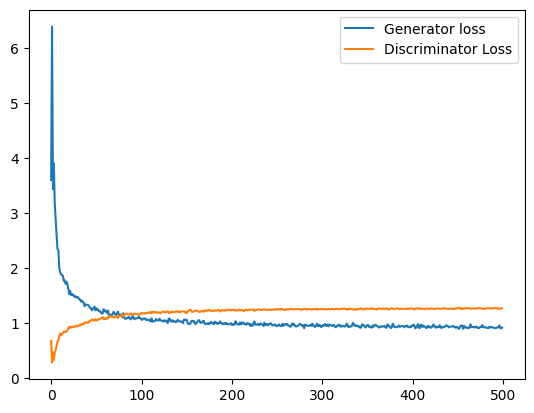

In [20]:
n_epoch = 500
D_losses_f, G_losses_f = [], []
for epoch in range(1, n_epoch+1):           
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in tqdm(enumerate(train_loader), total = 600):
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))
    D_losses_f.append(torch.mean(torch.FloatTensor(D_losses)))
    G_losses_f.append(torch.mean(torch.FloatTensor(G_losses)))
    with torch.no_grad():
        test_z = Variable(torch.randn(64, z_dim).to(device))
        generated = G(test_z)

        save_image(generated.view(generated.size(0), 1, 28, 28), f'./samples/sample{epoch}' + '.png')
    
plt.figure()
plt.plot(G_losses_f, label='Generator loss')
plt.plot(D_losses_f, label='Discriminator Loss')
plt.legend()
plt.show()

In [21]:
with torch.no_grad():
    for i in range(100):
        test_z = Variable(torch.randn(1, z_dim).to(device))
        generated = G(test_z)

        save_image(generated.view(generated.size(0), 1, 28, 28), f"samples/results{i}.png")

In [22]:
import pickle
with open('./model/G300.pickle','wb')as f: #python路径要用反斜杠
    pickle.dump(G,f) #将模型dump进f里面

FileNotFoundError: [Errno 2] No such file or directory: './model/G300.pickle'